# Project 15
Submitted by: Rohan Mehta

# Project 15: Text2SQL via Prompt Engineering

# Our Approach

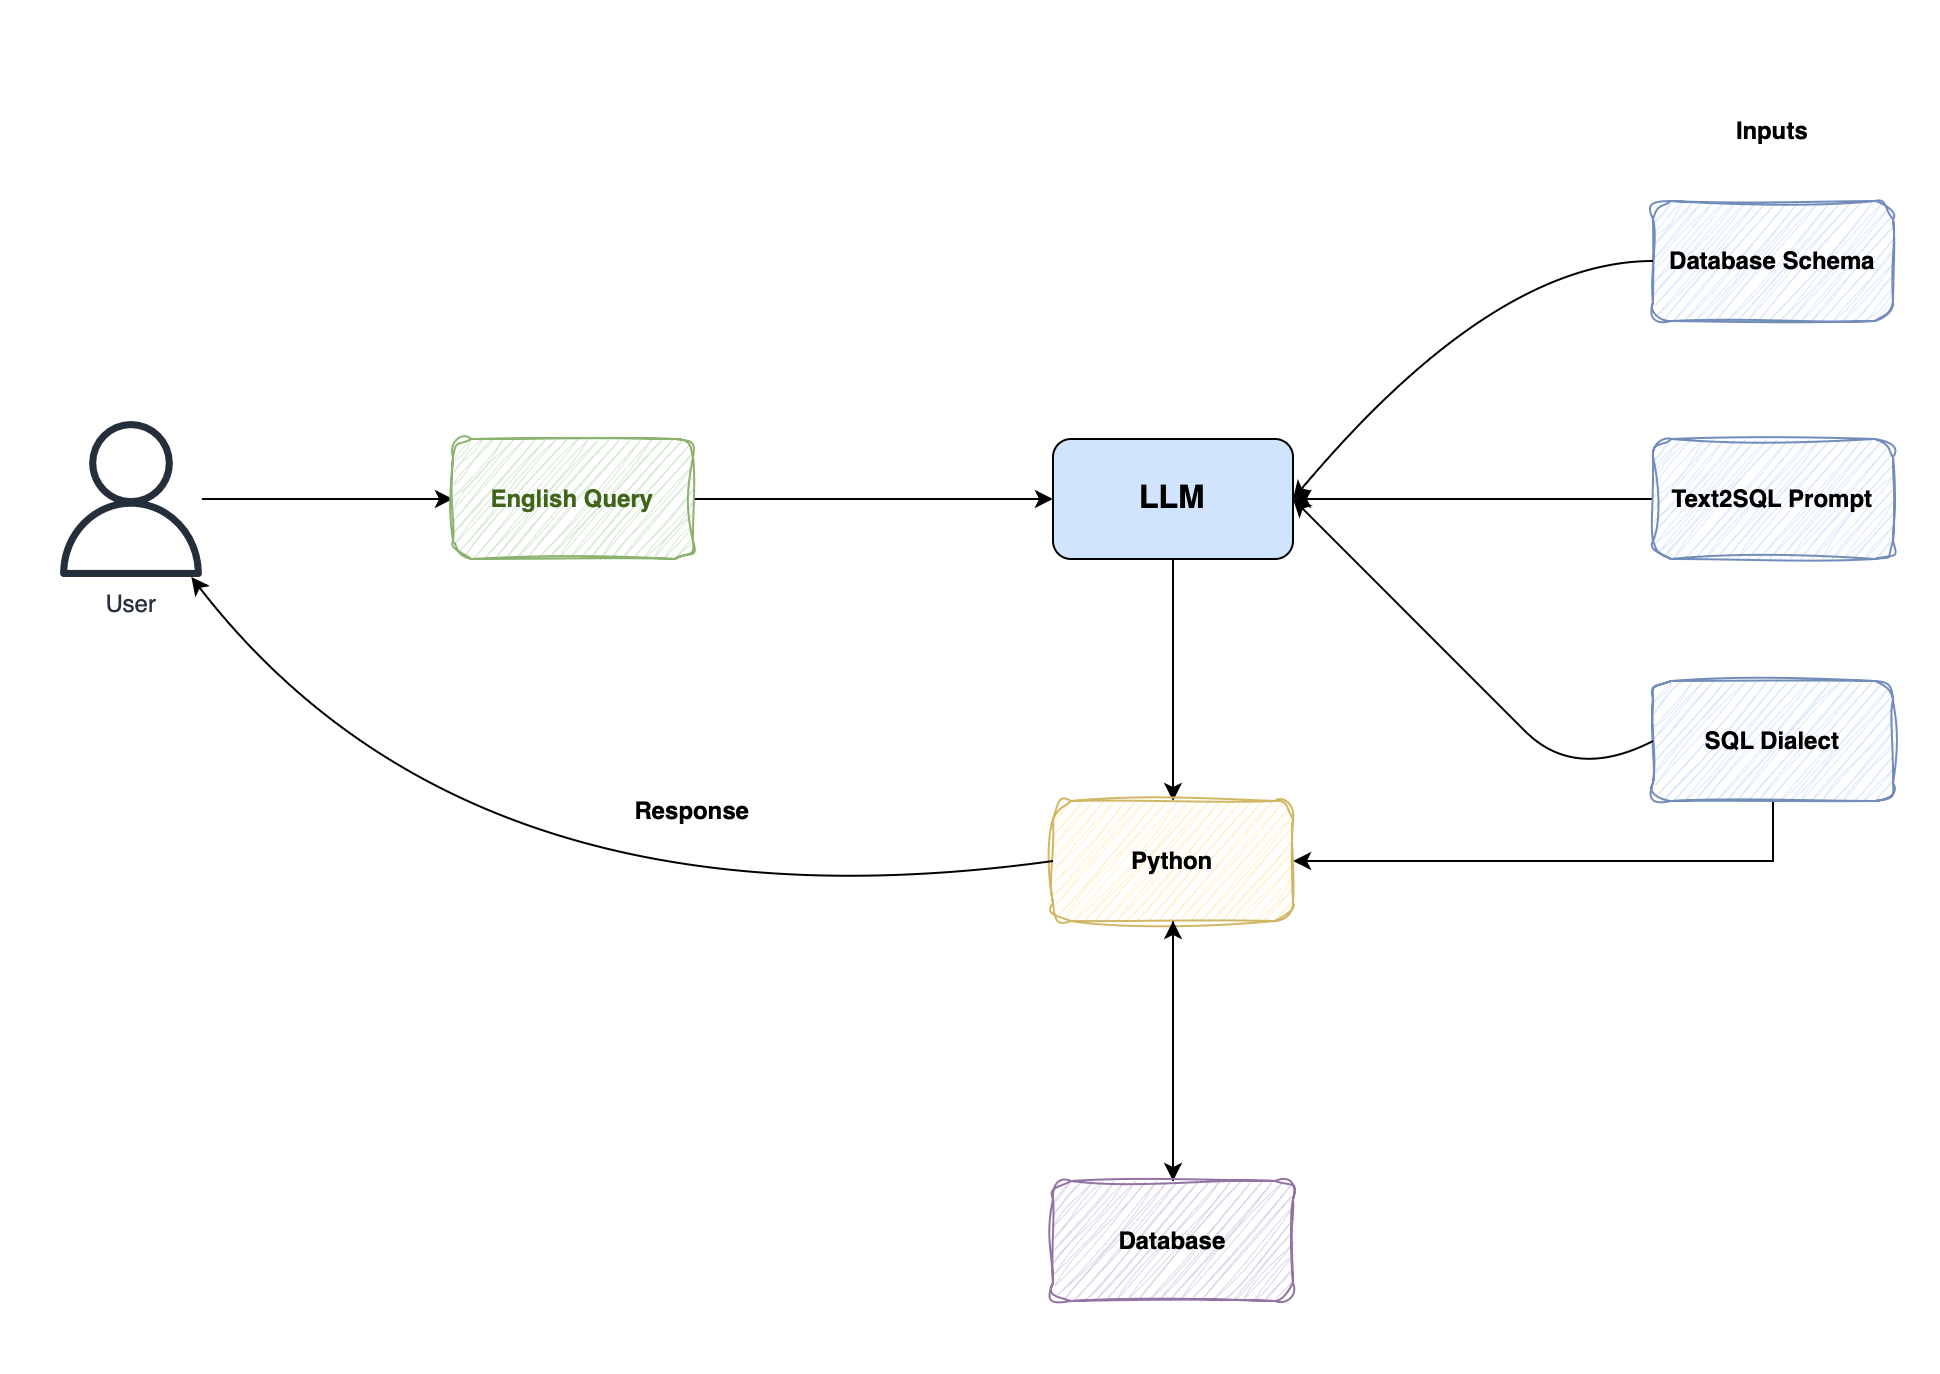

# Tangent 1: You should know about Mockaroo

http://mockaroo.com

## Retrieve data

In [ ]:
import pandas as pd

In [ ]:
!curl "https://api.mockaroo.com/api/697ae7c0?count=1000&key=59aa8700" > "employee_data.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 64236    0 64236    0     0  39084      0 --:--:--  0:00:01 --:--:-- 39096


In [ ]:
temp = pd.read_csv('/content/employee_data.csv')
temp.head()

,employee_id,first_name,last_name,email,phone_number,department_id,salary
0,1,Tiertza,Donahue,tdonahue0@tuttocitta.it,861-895-1639,7,91737
1,2,Teriann,Skamal,tskamal1@gizmodo.com,760-582-9097,4,142057
2,3,Lavina,Huglin,lhuglin2@ox.ac.uk,903-364-7233,2,95506
3,4,Monti,Thaw,mthaw3@nytimes.com,442-146-8112,1,70136
4,5,Birch,Lamperd,blamperd4@cam.ac.uk,342-405-5920,6,103970


In [41]:
!curl "https://api.mockaroo.com/api/d0dec2a0?count=7&key=59aa8700" > "department_data.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   188    0   188    0     0    238      0 --:--:-- --:--:-- --:--:--   238


In [42]:
temp_ = pd.read_csv('/content/department_data.csv')
temp_.head()

,department_id,department_name,location
0,1,HR,Zevenaar
1,2,Finance,Rakszawa
2,3,Engineering,Srabah
3,4,Sales,San Pedro Jocopilas
4,5,Marketing,Bailingnao


## Setup database

In [43]:
import sqlite3
import pandas as pd
import os

In [44]:
# Define SQL schemas for creating tables

employee_schema = """
                      CREATE TABLE IF NOT EXISTS employee_data (
                                                                  employee_id INT PRIMARY KEY,
                                                                  first_name VARCHAR(50),
                                                                  last_name VARCHAR(50),
                                                                  email VARCHAR(50),
                                                                  phone_number VARCHAR(50),
                                                                  department_id VARCHAR(2),
                                                                  salary INT
                                                                );
                  """

department_schema = """
                          CREATE TABLE IF NOT EXISTS department_data (
                                                                        department_id VARCHAR(2),
                                                                        department_name VARCHAR(50),
                                                                        location VARCHAR(50)
                                                                      );
                    """

In [45]:
db_name = 'employee.db'
if os.path.exists(db_name):
    os.remove(db_name)
    print(f"Removed existing database '{db_name}'.")

Removed existing database 'employee.db'.


In [46]:
import sqlite3
import pandas as pd
import os

COLUMN_DATA_TYPES = {
                      'employee_data': {
                                          'employee_id': 'int64',
                                          'first_name': 'object',
                                          'last_name': 'object',
                                          'email': 'object',
                                          'phone_number': 'object',
                                          'department_id': 'object',
                                          'salary': 'int64'
                                        },
                      'department_data': {
                                            'department_id': 'object',
                                            'department_name': 'object',
                                            'location': 'object'
                                          }
                      }

# --- Database setup ---
db_name = 'employee.db'
conn = None  # Initialize connection to None

try:
    # Establish a connection to the SQLite database
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    print(f"Database '{db_name}' created and connected successfully. ✅")

    # Create tables
    cursor.execute(employee_schema)
    cursor.execute(department_schema)
    print("Tables 'employee_data', and 'department_data' created successfully.")

    # --- Load data from CSV files into the tables using pandas ---
    csv_to_table_map = {
        '/content/employee_data.csv': 'employee_data',
        '/content/department_data.csv': 'department_data',
    }

    for csv_file, table_name in csv_to_table_map.items():
        if os.path.exists(csv_file):
            print(f"\nProcessing '{csv_file}' for table '{table_name}'...")

            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(csv_file)

            # 1. Get the expected schema for the current table
            expected_schema = COLUMN_DATA_TYPES[table_name]
            expected_cols = list(expected_schema.keys())

            # 2. Handle missing/extra columns
            # Drop columns from DataFrame that are not in the schema
            df = df[df.columns.intersection(expected_cols)]

            # Add any missing columns and fill with None (which becomes NULL in SQL)
            for col in expected_cols:
                if col not in df.columns:
                    df[col] = None

            # 3. Reorder columns to match the defined schema exactly
            df = df[expected_cols]

            # 4. Enforce data types
            for col, dtype in expected_schema.items():
                if 'datetime' in dtype:
                    # Use pd.to_datetime for date/time columns, coercing errors to NaT (Not a Time)
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                else:
                    # Use astype for other columns, handling potential conversion errors
                    try:
                        df[col] = df[col].astype(dtype)
                    except (ValueError, TypeError) as e:
                        print(f"  - Warning: Could not convert column '{col}' to {dtype}. Error: {e}. Leaving as is.")


            # Use the to_sql method to insert the cleaned DataFrame
            df.to_sql(table_name, conn, if_exists='append', index=False)
            print(f"  -> Data from '{csv_file}' loaded into '{table_name}' table successfully.")
        else:
            print(f"Warning: '{csv_file}' not found. Skipping data load for '{table_name}'.")

    # Commit the changes to the database
    conn.commit()
    print("\nData committed to the database successfully. 🎉")

except sqlite3.Error as e:
    print(f"Database error: {e}")
except pd.errors.EmptyDataError as e:
    print(f"Pandas error: {e}. One of the CSV files might be empty.")
except KeyError as e:
    print(f"Schema definition error: A column is missing from the TABLE_DATA_TYPES dictionary: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
finally:
    # Close the connection if it was established
    if conn:
        conn.close()
        print("Database connection closed.")

Database 'employee.db' created and connected successfully. ✅
Tables 'employee_data', and 'department_data' created successfully.

Processing '/content/employee_data.csv' for table 'employee_data'...
  -> Data from '/content/employee_data.csv' loaded into 'employee_data' table successfully.

Processing '/content/department_data.csv' for table 'department_data'...
  -> Data from '/content/department_data.csv' loaded into 'department_data' table successfully.

Data committed to the database successfully. 🎉
Database connection closed.


# Tangent 2: You should setup your free API Key using Google's AI Studio

https://aistudio.google.com/


And, the key as `Secrets` in Colab.

### Install Gen AI library

We will be installing of the google-generativeai package, the official Python SDK for the Gemini API.

In [26]:
!pip install google-genai

### Import required modules

In [27]:
from google import genai
from google.colab import userdata

In [28]:
genai_client = genai.Client(api_key=userdata.get('GEMINI_API_KEY'))

In [29]:
prompt = """

###ROLE###
You are a highly skilled Text-to-SQL translator with expertise in SQL syntax, database schema interpretation, and natural language understanding. You generate syntactically correct and semantically accurate SQL queries based on user input and a given database schema.

###CONTEXT###
The user is working with a relational database for an company. The database includes two main tables: `employee_data`, and `department_data`. The goal is to allow users to input natural language queries (in English), and have the model return equivalent SQL statements that accurately extract the requested data using the given schema.

Here is the full schema:

**employee_data Table**
```sql
CREATE TABLE IF NOT EXISTS employee_data (
  employee_id INT PRIMARY KEY,
  first_name VARCHAR(50),
  last_name VARCHAR(50),
  email VARCHAR(50),
  phone_number VARCHAR(50),
  department_id VARCHAR(2),
  salary INT
);
````

**department_data Table**

```sql
CREATE TABLE IF NOT EXISTS department_data (
    department_id VARCHAR(2),
    department_name VARCHAR(50),
    location VARCHAR(50)
  );
```
###TASK###
Your task is to:

1. Read a natural language query about the company.
2. Interpret the user's intent based on the schema provided.
3. Generate a valid SQL `SELECT` query that returns the expected result.
4. Ensure correct table joins, column selection, filtering, and grouping as necessary.
5. Handle aggregate functions (e.g., `COUNT`, `AVG`, `SUM`) where appropriate.
6. Disambiguate user terms based on schema details (e.g., "vertical" → `department`, "earnings" → `salary`, etc.).

###CONSTRAINTS###

* Only return a valid SQL query as output — no explanations or extra text.
* The user is using sqllite database - respond with correct and valid sqllite syntax
* Use aliases (`AS`) for column names only when the original name is ambiguous.
* Do not create or modify tables.
* Do not assume the existence of tables or columns not provided in the schema.
* Avoid subqueries unless absolutely necessary for correctness or performance.
* Prefer readability: indent joins and clauses properly.

###EXAMPLES###
**Input:** "Show me the names and emails of customers from Canada who have more than 1000 loyalty points."
**Output:**

```sql
SELECT first_name, last_name, email
FROM customers
WHERE country = 'Canada' AND loyalty_points > 1000;
```

**Input:** "Show the first and last names of all employees working in the Finance department.."
**Output:**

```sql
SELECT e.first_name, e.last_name
FROM employee_data e
JOIN department_data d
ON e.department_id = d.department_id
WHERE d.department_name = 'Finance';
```

**Input:** "What is the average salary of employees in each department?"
**Output:**

```sql
SELECT d.department_name, AVG(e.salary) AS avg_salary
FROM employee_data e
JOIN department_data d
ON e.department_id = d.department_id
GROUP BY d.department_name;

```

**Input:** "List the employee names and their department locations for employees earning more than 80000."
**Output:**

```sql
SELECT e.first_name, e.last_name, d.location
FROM employee_data e
JOIN department_data d
ON e.department_id = d.department_id
WHERE e.salary > 80000;

```

###OUTPUT FORMAT###
Return only the sqllite SQL query as a code block using triple backticks and the `sql` language tag, like this:

```sql
-- Your SQL query here
```
"""

In [34]:
import json
def get_sql_query_via_gemini(genai_client, prompt, user_query):

  # https://www.geeksforgeeks.org/python/formatted-string-literals-f-strings-python/
  contents = f"""
  {prompt}

  Here's the user query in english you need to work on:
  {user_query}
  """
  response = genai_client.models.generate_content(model='gemini-2.5-flash', contents=contents)
  # response = genai_client.models.generate_content(model='gemini-2.5-pro', contents=contents)

  # print(response) # uncomment this and understand at the output

  # Access the usage_metadata attribute
  usage_metadata = response.usage_metadata

  # Print the different token counts
  print(f"Input Token Count: {usage_metadata.prompt_token_count}")
  print(f"Thoughts Token Count: {response.usage_metadata.thoughts_token_count}")
  print(f"Output Token Count: {usage_metadata.candidates_token_count}")
  print(f"Total Token Count: {usage_metadata.total_token_count}")

  output = response.text.replace('```sql', '').replace('```', '')

  return output


In [37]:
import sqlite3
import pandas as pd

def execute_query(query, db_name='employee.db'):

    conn = None
    try:
        # Connect to the database
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()

        # Execute the query
        print(f"\nExecuting query on '{db_name}':\n{query}")
        cursor.execute(query)

        # Fetch all results
        results = cursor.fetchall()

        # Get column names from the cursor description
        columns = [description[0] for description in cursor.description]

        # Format results as a dataframe for easier use
        results_as_dict = [dict(zip(columns, row)) for row in results]
        results_df = pd.DataFrame(results_as_dict)

        print("Query executed successfully.")
        return results_df

    except sqlite3.Error as e:
        print(f"Database error executing query: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None
    finally:
        if conn:
            conn.close()

In [32]:
def text2sql(genai_client, prompt, user_query):
  output = get_sql_query_via_gemini(genai_client, prompt, user_query)
  results = execute_query(output)
  return results

In [47]:
text2sql(genai_client, prompt, "Show me the employee count by department")

Input Token Count: 896
Thoughts Token Count: 86
Output Token Count: 58
Total Token Count: 1040

Executing query on 'employee.db':

SELECT d.department_name, COUNT(e.employee_id) AS employee_count
FROM employee_data e
JOIN department_data d
ON e.department_id = d.department_id
GROUP BY d.department_name;

Query executed successfully.


,department_name,employee_count
0,Engineering,124
1,Finance,137
2,HR,157
3,IT,136
4,Marketing,149
5,Operations,144
6,Sales,153


In [48]:
text2sql(genai_client, prompt, "Show top 10 employees by salary")

Input Token Count: 897
Thoughts Token Count: 78
Output Token Count: 31
Total Token Count: 1006

Executing query on 'employee.db':

SELECT first_name, last_name, salary
FROM employee_data
ORDER BY salary DESC
LIMIT 10;

Query executed successfully.


,first_name,last_name,salary
0,Salli,Bytheway,149746
1,Carlynne,Crosham,149592
2,Nikki,Rooksby,149589
3,Edita,Cattrall,149240
4,Flem,Coker,149238
5,Norene,Brosel,148946
6,Pepillo,Pingstone,148720
7,Marilee,Conkay,148702
8,Alric,McCuthais,148494
9,Silvanus,Keoghan,148310


In [51]:
text2sql(genai_client, prompt, "Show the total salaries department wise sorted in descending order")

Input Token Count: 899
Thoughts Token Count: 170
Output Token Count: 63
Total Token Count: 1132

Executing query on 'employee.db':

SELECT d.department_name, SUM(e.salary) AS total_salary
FROM employee_data e
JOIN department_data d
ON e.department_id = d.department_id
GROUP BY d.department_name
ORDER BY total_salary DESC;

Query executed successfully.


,department_name,total_salary
0,Sales,14269361
1,HR,13993906
2,Marketing,13491709
3,IT,12763619
4,Operations,12517123
5,Finance,12114268
6,Engineering,11327650


In [53]:
text2sql(genai_client, prompt, "Show count of employees and average salary department wise order by descending?")

Input Token Count: 902
Thoughts Token Count: 83
Output Token Count: 76
Total Token Count: 1061

Executing query on 'employee.db':

SELECT d.department_name, COUNT(e.employee_id) AS employee_count, AVG(e.salary) AS average_salary
FROM employee_data e
JOIN department_data d
ON e.department_id = d.department_id
GROUP BY d.department_name
ORDER BY average_salary DESC;

Query executed successfully.


,department_name,employee_count,average_salary
0,IT,136,93850.139706
1,Sales,153,93263.797386
2,Engineering,124,91352.016129
3,Marketing,149,90548.382550
4,HR,157,89133.159236
5,Finance,137,88425.313869
6,Operations,144,86924.465278


# Submission Details

Can you create dataset for employees with at least 2 tables, and share the results in a notebook?